In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from dataclasses import dataclass

In [108]:
Call = 0
Put = 1

Buy =   1
Sell = -1

@dataclass
class Option:
    strike: float
    callput: float
    buysell: bool
    price: float = None
    qty: float = 100
        
    def __repr__(self):
        name = 'Call' if self.call else 'Put'
        
        args = [
            f'{self.strike:.2f}',
            'Buy' if self.buy else 'Sell',
        ]
        
        if self.price:
            args.append(f'{self.price:.2f}')
        
        args = ', '.join(args)
        return f'{name}({args})'
        
    @property
    def sell(self):
        return self.buysell == Sell
    
    @property
    def buy(self):
        return self.buysell == Buy

    @property
    def put(self):
        return self.callput == Put
    
    @property
    def call(self):
        return self.callput == Call
    
    def payoff(self, price):
        if self.call:
            return self.buysell * max(price - self.strike, 0)
        
        if self.put:
            return self.buysell * max(self.strike - price, 0)
        
    def profit(self, price):
        return self.payoff(price) + self.cost()
    
    def _prices(self, spread):
        return [
            self.strike / spread,
            self.strike,
            self.strike * spread,
        ]
    
    def cost(self):
        return - self.buysell * self.price
            
    def show(self, spread=1.12):
        strikes = self._prices(spread)
        plt.plot(strikes, [self.payoff(k) for k in strikes])
        
        
Option(4210, Call, Buy, 10).cost()
# Option(4210, Call, Sell).show()
Option(4210, Put, Buy, 10).cost()
# Option(4210, Put, Sell).show()

-10

In [114]:
import pandas as pd


def guess_plot_spread(options):
    avg = sum([opt.strike for opt in options]) / len(options)
    return max([opt.strike / avg for opt in options])

def generate_plot_prices(options, spread):
    prices = []
    for opt in options:
        prices.append(opt.strike)
    prices.sort()
    
    prices.insert(0, int(prices[0] / spread))
    prices.append(int(prices[-1] * spread))
    return prices

def display_strategy(options, spread=None, profit=True):
    # Guess a nice spread given the price of every strike
    if spread is None:
        spread = guess_plot_spread(options)
    
    prices = generate_plot_prices(options, spread)
    cost = sum([opt.cost() for opt in options])
    
    payoffs = []
    profits = []
    for price in prices:
        value = sum([opt.payoff(price) for opt in options])
        payoffs.append(value)
        
        value = sum([opt.profit(price) for opt in options])
        profits.append(value)
        
    print(f"Cost {cost:.2f}")
    y = profits if profit else payoffs
    plt.plot(prices, y)
    return pd.DataFrame(dict(prices=prices, payoff=payoffs, profit=profits))

Cost 0.58


,prices,payoff,profit
0,4180,0,0.58
1,4195,0,0.58
2,4205,10,10.58
3,4215,10,10.58
4,4225,0,0.58
5,4240,0,0.58


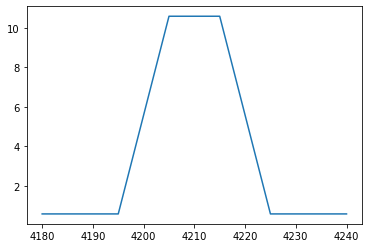

In [115]:
display_strategy([
    Option(4195, Call, Buy , 58.45),
    Option(4205, Call, Sell, 53.24),
    Option(4215, Call, Sell, 46.78),
    Option(4225, Call, Buy , 40.99),
])

In [113]:
def condor_call(strike, spread, inner):
    return [
        Option(strike - (spread + inner), Call, Buy),
        Option(strike - inner, Call, Sell),
        Option(strike + inner, Call, Sell),
        Option(strike + (spread + inner), Call, Buy),
    ]